# Deep Reinforcement Learning: Box World Navigation

---
This notebook contains the solution to the [Udacity Deep Reinforcement Learning Nano Degree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)  project one. The objective of the project is to design and implement a deep reinforcement learning agent, using the DQN algorithm, that is able to solve the custom [Unity](https://blogs.unity3d.com/2017/09/19/introducing-unity-machine-learning-agents/)-Udacity Banana Collector environment.

![bananaworld](https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif)

The agent is given zero prior knowledge of the game and is tasked with learning a policy (based on the action-value function) that will allow it to maximize the  game score. The score is determined by the number and color of bananas that are collected inside the Box World: +1 for each yellow banana collected, -1 for each black banana collected. The game is considered solved upon achieving a score of +13 or higher.

In addition to the modified Unity environment, the implementation relies on the [PyTorch](https://pytorch.org/) tensor library.

### 1. Import Necessary Libraries and Environment

In [0]:
# Standard Imports
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# Install and Import Unity ML-Agents
!pip -q install ml-agents-master/python
from unityagents import UnityEnvironment

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### 2. Load the Banana Collector Environment
Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [0]:
# Load custom Udacity Banana Brain (Unity 'Brain' <-> Environment)
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [0]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Get a "Feel" for the Banana Collector Environment

Examine the State and Action Spaces. Run the code cell below to print some information about the environment and a sample state vector.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [0]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Play a single episode with randomly generated actions. Learn how to use the Python API to control the agent and receive feedback from the environment.

In [0]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### 4. Design a Deep Reinforcement Learning (DRL) Agent

The Deep RL Agent is an implementaiton of the Sarsamax algorithm, also known as [Deep Q-Learning (DQN)](https://deepmind.com/research/dqn/).

The first model component of the agent is the **deep neural network** implemented with PyTorch. This model will learn an optimal mapping between the 37-dimensional input space and the 4-dimensional action space. In terms of **architecture**, the network contains:
- **three fully-connected (FC) hidden layers** (in a 16-32-64 hidden unit configuration) with ReLU non-linear activation functions
- **one fully-connected linear output layer**

**Important Note** 

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [0]:
# QNetwork Class
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=16, fc2_units=32, fc3_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

The second model component of the agent class, the body of the code, is the portion that interacts with the environment and iteratively learns an improved action-value function. 

Generally, the **learning process** functions as follows:
1. the agent receives/observes a state vector (S) from the environment
2. it then passes the state to the action-value network, $Q$, to decide an optimal action, $a_t^*$
4. after taking the action, the agent observes a resulting reward, $R_t$, and transition state, $S_{t+1}$. This sequence, $SARS'A$, is saved into a 'replay buffer'.
5. The agent then updates the action-value network by:
  - sampling observations (SARS'A-tuples) from the replay buffer
  - pass the sample (R, S')-tuples into a copy of the network (which mitigates instability) in order to generate an estimate of the expected discounted reward 
  - use the estimates as target values to update the network parameters. Specifically,  minimize the mean-squared error (MSE) with gradient descent (Adam optimizer).  
  
Some elements of the algorithm deserve more concrete mathematical notation:

- An **action-value network** is defined, $Q(S_t,A_t,w)$, that maps each state, $S_t=s_t$, to an action-values, $a_t$, according to the learned parameters, $w$. The network weights,  $w$, are initialzed randomly.
- Given the action-value function $Q(S_t,A_t,w)$, **actions are selected** at each step according to:
$$a_t^* = argmax_{a_t \in A(s_t)} Q(S_t=s_t, A_t=a_t)$$
- The **objective function** used to train the model (find the optimal $w$) is:
$$ argmax_w \Theta = (Q(s_t, a_t, w^-) - \hat{Q}(s_t, a_t^*, w))^2 $$
where the 'true' target values (left term) are estimated according to:
$$Q(s_t, a_t, w^-) = R_t + \gamma \hat{Q}(s_{t+1}, a_{t+1}^*, w^-)$$
Note that $w^-$ is a **temporally-stable copy of the primary network weights**.

  
Certain **meta-parameters** must be specified and tuned to achieve optimal performance:
- Buffer Size: 100,000 samples
- Batch Size: 64
- $\gamma$: Discount factor for future rewards
- Learning Rate: 5E-5
- Update Target Model: Every 4 steps
- $\tau$: controls how aggressively the target model is updated/blended with the local model
- $\epsilon_{start}$: Starting epsilon value for determining how often to select the random action vs the greedy action
- $\epsilon_{end}$:  Terminal epsilon value for determining how often to select the random action vs the greedy action
- $\epsilon_{decay}$:  Parameter determining how quickly the epsilon value transitions during training


In [0]:
# Agent Class
#import numpy as np
#import random
#from collections import namedtuple, deque

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim

#from model import QNetwork

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
#LR = 5e-4               # learning rate 
LR = 5e-5               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        ?_target = ?*?_local + (1 - ?)*?_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [0]:
# instantiate agent
#from dqn_agent import Agent
agent = Agent(state_size=37, action_size=4, seed=0)

Episode 100	Average Score: 0.36
Episode 200	Average Score: 2.78
Episode 300	Average Score: 4.96
Episode 400	Average Score: 7.19
Episode 500	Average Score: 10.01
Episode 600	Average Score: 12.93
Episode 613	Average Score: 13.00
Environment solved in 513 episodes!	Average Score: 13.00


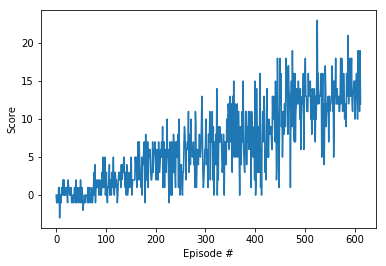

In [0]:
def dqn(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = int(agent.act(state, eps))
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            #print(t,'reward: ',reward, 'score: ',score,'done: ',done)
            
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(max_t=750)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [0]:
env.close()

### Future Directions
The training algorithm could benefit from some specific enhancements. 
- [Double Q-Learning](https://arxiv.org/abs/1509.06461): DQN tends to overestimate the action-values. This can be partially remedied by separating the action-value estimation function from the action-selection function.
- [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952): Some observations are more important than others. i.e. observations with very large positive or negative action-values. By sampling more heavily from these outsized-payoff observations, the algorithm is able to learn more efficiently.
- [Dueling DQN](https://arxiv.org/abs/1511.06581): Decompose the action-values, $Q(s,a)$ estimates into a state-value prediction, $V(s)$, and an action-advantage-values, $A(s,a)$: $$Q(s,a) = V(s) + A(s,a)$$.
- [Rainbow](https://arxiv.org/abs/1710.02298): Combining all of these enhancements into one product in addition to a number of other extensions (multi-strep bootstrap targets, distributional dqn, noisy dqn)